TODO : use dt / begin with bang bang solution

TODO :  copy the notebook 

TODO: put all functions in one script HW.py - use OO a bit like https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_learn.py#L9 - then just use the functions

TODO: cache data https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_experiments.py#L161 , just plot

TODO: explore parameters


TODO: apply on aSPEM / generalized coordinates / include delays

In [396]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

beta = 1
m = 10
A = np.array([[1., 1.],[0., 1-beta/m]])
B = np.array([0., 1/m])
k = 0.00001

dt = 0.002
t_T = .05
t_R = .05
T = int(t_T/dt)
R = int(t_R/dt)
time = np.linspace(0, t_T+t_R, R+T+1)
time_ms = time*1000
x0 = np.array([0., 0.])
xT = np.array([10., 0.])

def power(A, n): 
    """
    renvoie A puissance n où A est une matrice carrée
        
    """
    if n == 0:
        return(np.eye(int(np.sqrt(np.size(A)))))
    elif n == 1:
        return A
    else:
        if n % 2 == 0:
            A_half = power(A, n//2)
            return(A_half.dot(A_half))
        else:
            A_half = power(A, (n-1)//2)
            return(A.dot(A_half.dot(A_half)))
        # mod = n % 2
        # return power(A, mod).dot(power(A,(n-mod)//2))

def A_pow(A):
    A_pow_array = np.zeros((T+R+1,2,2))

    for i in np.arange(T+R+1):
        A_pow_array[i] = power(A,i)
    return A_pow_array

A_pow_array = A_pow(A)

def pow_fast(n):
    return A_pow_array[n]

ci0_array = np.zeros(T+R+1)

for i in np.arange(T+R+1):
    ci0_array[i] = (pow_fast(i).dot(B))[0]

ci1_array = np.zeros(T+R+1)

for i in np.arange(T+R+1):
    ci1_array[i] = (pow_fast(i).dot(B))[1]

ci = np.array([ci0_array,ci1_array])


def expectation(u, t):
    if t == 0:
        return x0
    else:
        somme =  pow_fast(t).dot(x0)
        somme += sum(np.transpose(ci[:,0:t]*np.flipud(u[0:t])))
        return somme
    
def variance(u, t):
    somme = (m**2)*k*sum(np.flipud(ci0_array[0:t]*ci0_array[0:t])*u[0:t]*u[0:t])
    return somme

def bias(u, t):
    mean = expectation(u, t)
    result = (mean-xT)**2
    return result

def cost(u):
    return sum(variance(u, t) + sum(bias(u, t)) for t in (T+1+np.arange(R))) + sum(bias(u,T))

def cost_deriv(u, i): # Derivative of the cost function with respect to u_i
    if i < T:
        return sum(sum(2*np.transpose(ci[:,(T-i-1):(T+R-i)])*([expectation(u,t).tolist() for t in (T+np.arange(R+1))]-xT))) + 2*(m**2)*k*u[i]*sum(ci0_array[(T+1-i-1):(T+R-i)]**2)
    elif i == T:
        return sum(sum(2*np.transpose(ci[:,0:R])*([expectation(u,t).tolist() for t in (T+1+np.arange(R))]-xT))) + 2*(m**2)*k*u[T]*sum(ci0_array[0:R]**2)
    else:
        return sum(sum(2*np.transpose(ci[:,0:(T+R-i)])*([expectation(u,t).tolist() for t in (i+1+np.arange(R+T-i))]-xT))) + 2*(m**2)*k*u[i]*sum(ci0_array[0:(T+R-i)]**2)

In [552]:
n_iter = 80000
eta = 0.0017

u = 0.5*np.ones(T+R+1)
u[T-1:T] *= -1
u[T:T+R+1] = 0
#np.random.seed(42)
#u = np.random.uniform(-5, 5, T+R+1)


a = np.zeros((n_iter+1, T+R+1)) # To save the evolution of the values of u at each iteration
u_old = np.zeros(T+R+1)
a[0, :] = u.copy()
for i_iter in np.arange(n_iter):
    u_old[0:(T+R)] = u[0:(T+R)].copy()
    u[0:T+R] = u_old[0:T+R] - eta*np.array([cost_deriv(u_old, i) for i in np.arange(T+R)])
    a[i_iter+1, :] = u.copy()

In [444]:
i_iter

533

In [447]:
u

array([  8.62614888e-01,   8.54224923e-01,   8.44755192e-01,
         8.34048616e-01,   8.21920992e-01,   8.08155336e-01,
         7.92494824e-01,   7.74633935e-01,   7.54207275e-01,
         7.30775398e-01,   7.03806700e-01,   6.72654162e-01,
         6.36525333e-01,   5.94443362e-01,   5.45196186e-01,
         4.87270056e-01,   4.18762403e-01,   3.37267690e-01,
         2.39728578e-01,   1.22243957e-01,  -2.01735048e-02,
        -1.93891691e-01,  -4.06990218e-01,  -6.69575267e-01,
        -1.04354956e+00,  -4.06622093e-01,  -1.17034737e-01,
        -1.18610278e-02,   1.26564820e-02,   1.14882811e-02,
         6.23176182e-03,   2.60025972e-03,   8.52312793e-04,
         1.87216902e-04,  -4.63603001e-06,  -2.95691297e-05,
        -1.38054313e-05,  -2.94752311e-07,   3.06866760e-06,
         7.24286188e-07,  -1.79469765e-06,  -2.14087811e-06,
        -9.03045814e-07,   3.97924634e-07,   8.61526116e-07,
         5.45122555e-07,  -1.07786099e-08,  -3.50525600e-07,
        -3.51571846e-07,

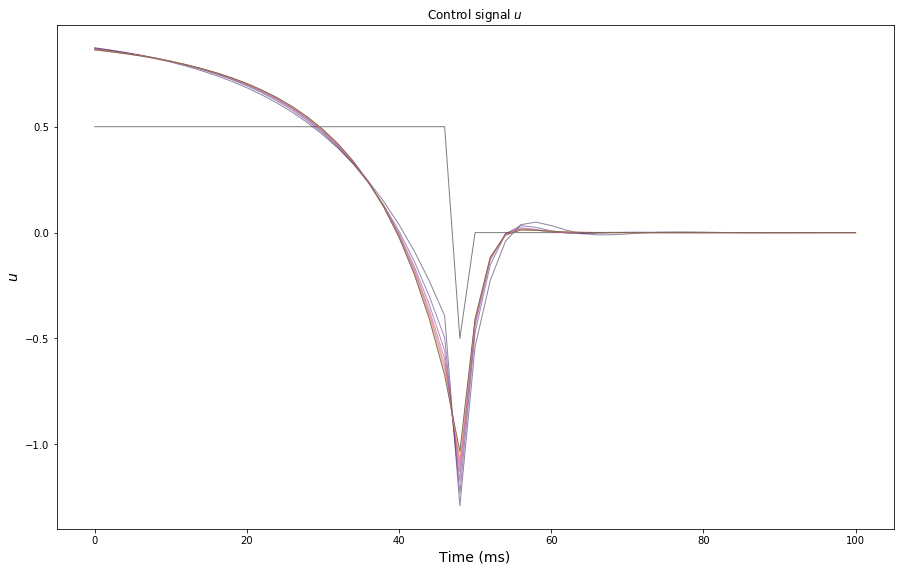

In [553]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
N_show = 10
from cycler import cycler
ax.set_prop_cycle(cycler('color', [plt.cm.magma(h) for h in np.linspace(0, 1, N_show)]))

ax.plot(time_ms, a[::(n_iter//N_show), :].T, '-', alpha=.5, lw=1)
ax.set_title(r'Control signal $u$')
ax.set_xlabel('Time (ms)', fontsize=14)
ax.set_ylabel(r'$u$', fontsize=14)

#ax.set_xlim(0, 150)

In [554]:
position = np.zeros((n_iter+1,T+R+1))
velocity = np.zeros((n_iter+1,T+R+1))

for i in np.arange(n_iter+1):
    for j in np.arange(T+R+1):
        mean = expectation(a[i,:], j)
        position[i,j] = mean[0]
        velocity[i,j] = mean[1]

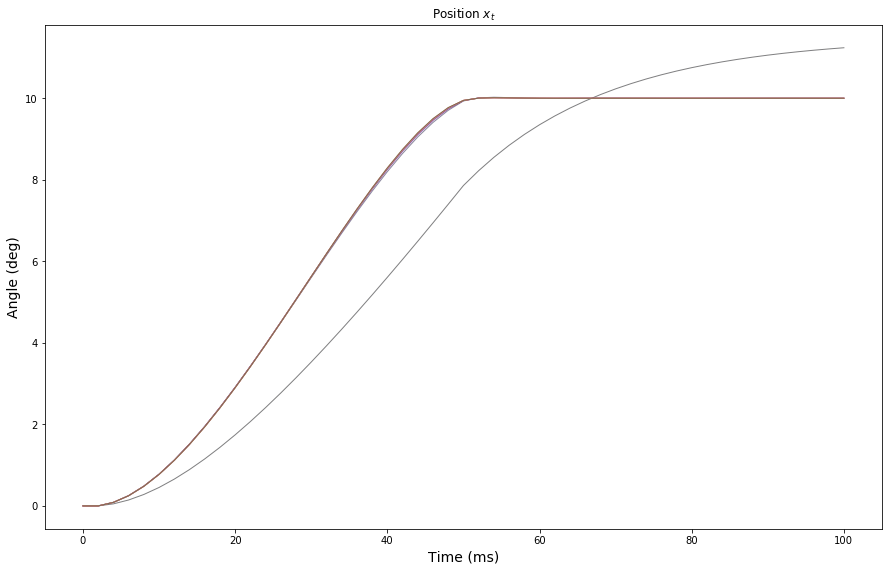

In [555]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
N_show = 10
from cycler import cycler
ax.set_prop_cycle(cycler('color', [plt.cm.magma(h) for h in np.linspace(0, 1, N_show)]))

ax.plot(time_ms, position[::(n_iter//N_show), :].T, '-', alpha=.5, lw=1)
ax.set_title(r'Position $x_t$')
ax.set_xlabel('Time (ms)', fontsize=14)
ax.set_ylabel('Angle (deg)', fontsize=14)
#ax.set_xlim(0, 150)


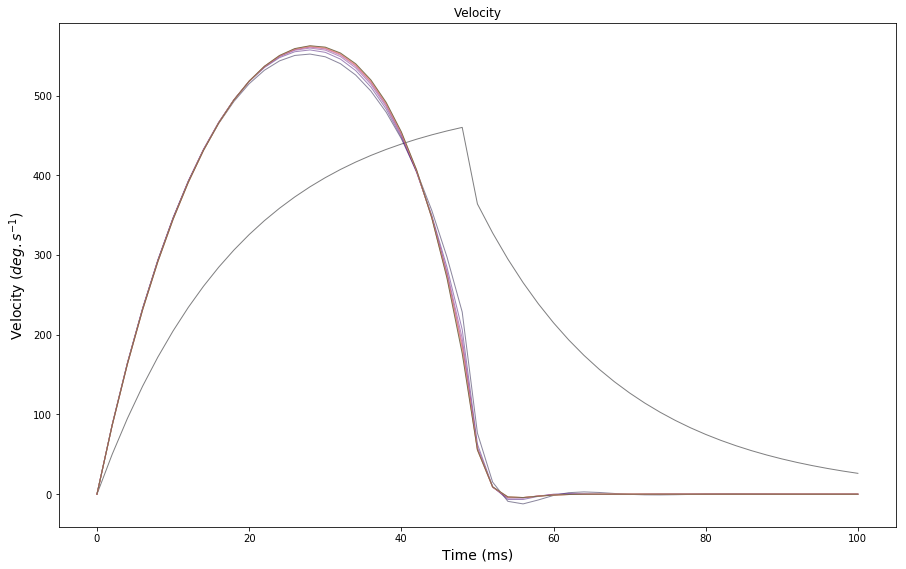

In [556]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
N_show = 10
from cycler import cycler
ax.set_prop_cycle(cycler('color', [plt.cm.magma(h) for h in np.linspace(0, 1, N_show)]))

ax.plot(time_ms, 1000*velocity[::(n_iter//N_show), :].T, '-', alpha=.5, lw=1)
ax.set_title('Velocity')
ax.set_xlabel('Time (ms)', fontsize=14)
ax.set_ylabel(r'Velocity $(deg.s^{-1})$ ', fontsize=14)
#ax.set_xlim(0, 150)


In [557]:
varia = np.zeros((n_iter+1,T+R+1))

for i in np.arange(n_iter+1):
    for j in np.arange(T+R+1):
        varia[i,j] = variance(a[i,:], j)

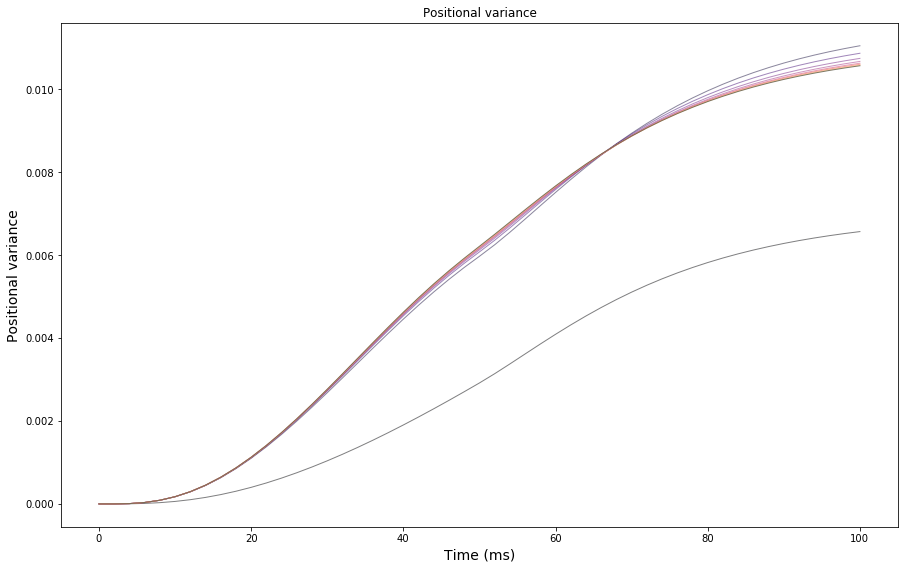

In [488]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
N_show = 10
from cycler import cycler
ax.set_prop_cycle(cycler('color', [plt.cm.magma(h) for h in np.linspace(0, 1, N_show)]))

ax.plot(time_ms, varia[::(n_iter//N_show), :].T, '-', alpha=.5, lw=1)
ax.set_title('Positional variance')
ax.set_xlabel('Time (ms)', fontsize=14)
ax.set_ylabel('Positional variance', fontsize=14)
#ax.set_xlim(0, 150)


In [462]:
cost_p = np.zeros(n_iter+1)

for i in np.arange(n_iter+1):
    cost_p[i] = cost(a[i])

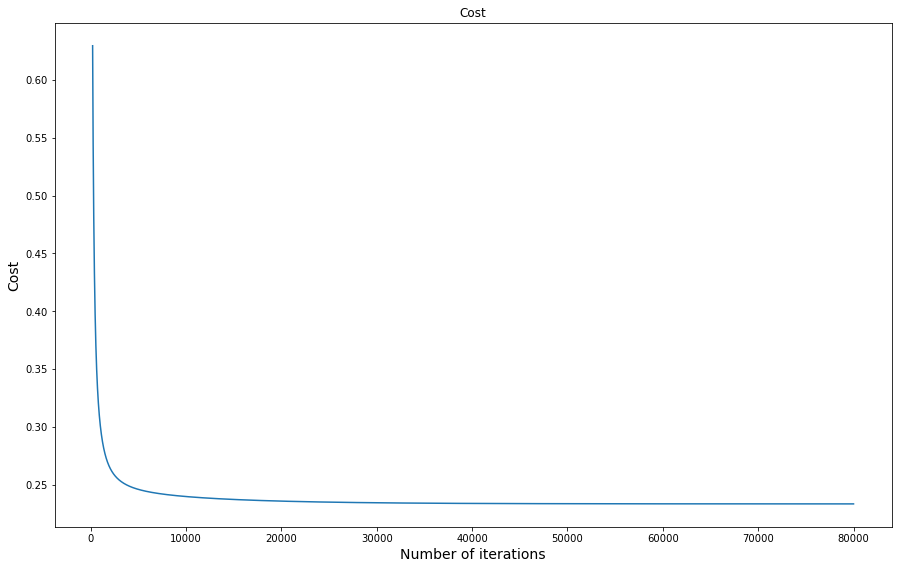

In [464]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))

ax.plot(200+np.arange(n_iter-200), cost_p[200:n_iter], '-')
ax.set_title('Cost')
ax.set_xlabel('Number of iterations', fontsize=14)
ax.set_ylabel('Cost', fontsize=14)
#ax.set_xlim(0, 150)


In [558]:
positionT = np.zeros(n_iter+1)

for i in np.arange(n_iter+1):
    positionT[i] = (expectation(a[i], T))[0]

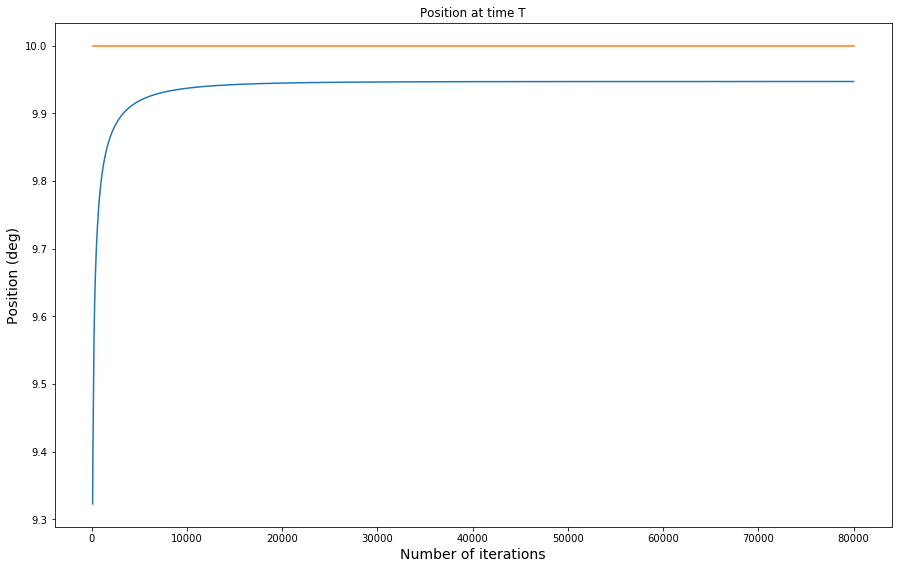

In [559]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))

ax.plot(100+np.arange(n_iter-100+1), positionT[100:n_iter+1], '-')
ax.set_title('Position at time T')
ax.set_xlabel('Number of iterations', fontsize=14)
ax.set_ylabel('Position (deg)', fontsize=14)
ax.plot([100,n_iter],[10,10])
#ax.set_xlim(0, 150)

In [560]:
velocityT = np.zeros(n_iter+1)

for i in np.arange(n_iter+1):
    velocityT[i] = (expectation(a[i], T))[1]

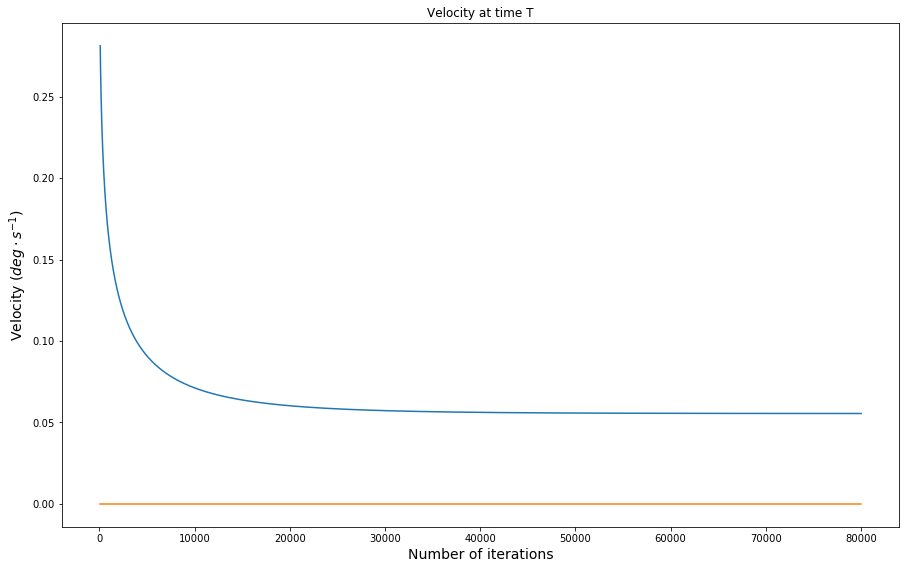

In [561]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))

ax.plot(100+np.arange(n_iter-100+1), velocityT[100:n_iter+1], '-')
ax.set_title('Velocity at time T')
ax.set_xlabel('Number of iterations', fontsize=14)
ax.set_ylabel(r'Velocity ($deg\cdot s^{-1}$)', fontsize=14)
ax.plot([100,n_iter],[0,0])
#ax.set_xlim(0, 150)